To plot the final figures

In [1]:
import numpy as np
from scipy.spatial.distance import cdist # For calculating QPSK decoding
# import dill
from itertools import product, cycle

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# import tensorflow.keras.backend as K

In [2]:
# The one who steals the data
def robinhood(fig, filename, col_dtype=[float, float], col_fmt=None):
    assert (len(fig.axes) < 2), "More than one axis not supported"
    ax = fig.axes[0]
    
    header = []
    fmt = []
    
    # Don't modify the argument here, it will get updated for all the following calls
    if not col_fmt:
        _col_fmt = [ "%d" if d == int else "%.5f" for d in col_dtype ]
    else:
        _col_fmt = col_fmt.copy()
    
    n_lines = len(ax.lines)
    x_data = ax.lines[0].get_xdata()
    
    data = np.zeros((x_data.shape[0], 2 * n_lines))
    
    for(i, line) in enumerate(ax.lines):
        data[:, 2*i] = line.get_xdata()
        data[:, 2*i+1] = line.get_ydata()
        
        header += ["x_" + line.get_label(), "y_" + line.get_label()]
        fmt += _col_fmt
            
    if filename is not None:
        with open(filename, 'w') as f:
            f.write(",".join(header) + "\n")
            np.savetxt(f, data, delimiter=",", fmt=",".join(fmt))

In [3]:
blkSize     = 8
chDim       = 4

# Input
inVecDim   = 2 ** blkSize  # 1-hot vector length for block
encDim = 2*chDim

SNR_range_dB = np.arange( 0.0, 40.1, 2.0 )

one_hot_code = np.eye(inVecDim)

Traditional Methods

In [4]:
results_traditional = {}

In [5]:
def rbf_channel(txBlk, n0):
    N, dim = txBlk.shape
    
    p1 = txBlk[:,:]
    p2 = np.hstack((-txBlk[:,dim//2:],txBlk[:,:dim//2]))
    
    h1 = np.sqrt(1.0/encDim) * np.random.randn(N)
    h2 = np.sqrt(1.0/encDim) * np.random.randn(N)
    
    outBlk = h1[:,None]*p1 + h2[:,None]*p2 + np.random.normal(scale=np.sqrt(n0), size=txBlk.shape)
    
    return outBlk, h1, h2

In [6]:
def rbf_channel_nonoise(txBlk):
    N, dim = txBlk.shape
    
    p1 = txBlk[:,:]
    p2 = np.hstack((-txBlk[:,dim//2:],txBlk[:,:dim//2]))
    
    h1 = np.sqrt(1.0/encDim) * np.random.randn(N)
    h2 = np.sqrt(1.0/encDim) * np.random.randn(N)
    
    outBlk = h1[:,None]*p1 + h2[:,None]*p2
    
    return outBlk, h1, h2

In [7]:
def add_pilot(txBlk, pilotSym):
#     pilotSym = [+1.0, +1.0]
    blkWithPilot = np.insert(txBlk, [0,chDim], values=pilotSym, axis=1)
    
    return blkWithPilot

In [8]:
def equalizer(rxBlk, pilotSym):
#     pilotSym = [+1.0, +1.0]
    
    N, dim = rxBlk.shape
#     print("eq>> rxBlk =", rxBlk)
    
    p1 = rxBlk[:,:]
    p2 = np.hstack((-rxBlk[:,dim//2:],rxBlk[:,:dim//2]))
    
    rxPilots = rxBlk[:,[0,1+chDim]]
    
    h1_hat = (pilotSym[1]*rxPilots[:,1]+pilotSym[0]*rxPilots[:,0])/(pilotSym[1]**2+pilotSym[0]**2)
    h2_hat = (pilotSym[0]*rxPilots[:,1]-pilotSym[1]*rxPilots[:,0])/(pilotSym[1]**2+pilotSym[0]**2)
    
#     print( "eq>> h1_hat:", h1_hat)
#     print( "eq>> h2_hat:", h2_hat)
    
    
    z1_hat = rxBlk[:,:dim//2]
    z2_hat = rxBlk[:,dim//2:]
    
#     print("eq>> z1_hat =", z1_hat)
#     print("eq>> z2_hat =", z2_hat)
    
    
#     print(h1_hat.shape, h2_hat.shape, z1_hat.shape, z2_hat.shape)
    
    zR = (h1_hat[:,None]*z1_hat+h2_hat[:,None]*z2_hat) / (h1_hat[:,None]**2+h2_hat[:,None]**2)
    zI = (h1_hat[:,None]*z2_hat-h2_hat[:,None]*z1_hat) / (h1_hat[:,None]**2+h2_hat[:,None]**2)
    
#     print("eq>>zR =", zR)
#     print("eq>>zI =", zI)
    
    outBlk = np.hstack((zR[:,1:],zI[:,1:]))
    
    return outBlk, h1_hat, h2_hat

In [9]:
qam_map = np.genfromtxt("./../../AWGN/sphere_data/{:03d}x{:03d}_qam.csv".format(inVecDim,encDim))
qam_sym_pow = np.mean(np.sum(qam_map*qam_map,axis=1))
print( "QAM Avg. Tx Power:", qam_sym_pow )

qam_d_min = np.unique(cdist(qam_map,qam_map))[1]
print("d_min:", qam_d_min )

qam_en = qam_sym_pow / (qam_d_min**2)
print("En:", qam_en)

# calculate the pilot symbol
qam_pilotSym = np.sqrt(qam_sym_pow/encDim) * np.ones(2)

noisePower = qam_sym_pow * 10.0**(-SNR_range_dB/10.0)
n0_per_comp = noisePower/(2*chDim+2)

QAM Avg. Tx Power: 8.0
d_min: 2.0
En: 2.0


In [10]:
err = []
for n0 in n0_per_comp:
  thisErr = 0
  thisCount = 0

  while thisErr < 500 and thisCount < 5000000:
    txSym = np.random.randint(inVecDim, size=1000)
    symBlk = qam_map[txSym]
    txTest = add_pilot(symBlk, qam_pilotSym)
    rxTest, _, _ = rbf_channel(txTest, n0)
    rxEqualized, _, _ = equalizer(rxTest, qam_pilotSym)
    rxDecode = cdist(rxEqualized, qam_map)
    rxSym = np.argmin(rxDecode,axis=1)
    thisErr += np.sum(rxSym!=txSym)
    thisCount += 1000
  err.append(thisErr/thisCount)

results_traditional["QAM"] = {
    "en": qam_en,
    "dmin": qam_d_min,
    "sym_pow": qam_sym_pow,
    "bler": np.array(err)
}

In [11]:
agrell_map = np.genfromtxt("./../../AWGN/sphere_data/{:03d}x{:03d}_agrell.csv".format(inVecDim,encDim))
agrell_sym_pow = np.mean(np.sum(agrell_map*agrell_map,axis=1))
print( "QAM Avg. Tx Power:", agrell_sym_pow )

noisePower = agrell_sym_pow * 10.0**(-SNR_range_dB/10.0)
n0_per_comp = noisePower/(2*chDim)

agrell_d_min = np.unique(cdist(agrell_map,agrell_map))[1]
print("d_min:", agrell_d_min )

agrell_en = agrell_sym_pow / (agrell_d_min**2)
print("En:", agrell_en)

agrell_map = np.sqrt(blkSize/agrell_sym_pow) * agrell_map
# agrell_map = np.sqrt(1.0/agrell_sym_pow) * agrell_map
agrell_sym_pow = np.mean(np.sum(agrell_map*agrell_map,axis=1))
print( "Normalized Agrell Avg. Tx Power:", agrell_sym_pow )

# calculate the pilot symbol
agrell_pilotSym = np.sqrt(agrell_sym_pow/encDim) * np.ones(2)
# agrell_pilotSym = 10.0*np.ones(2)

noisePower = agrell_sym_pow * 10.0**(-SNR_range_dB/10.0)
n0_per_comp = noisePower/(2*chDim+2)
# print("Agrell n0 =", n0_per_comp)

QAM Avg. Tx Power: 137610.0
d_min: 362.03867196751236
En: 1.0498809814453123
Normalized Agrell Avg. Tx Power: 7.999999999999997


In [12]:
err = []
for n0 in n0_per_comp:
  thisErr = 0
  thisCount = 0
  while thisErr < 500 and thisCount < 5000000:
    txSym = np.random.randint(inVecDim, size=1000)
    symBlk = agrell_map[txSym]
    txTest = add_pilot(symBlk, agrell_pilotSym)
    rxTest, _, _ = rbf_channel(txTest, n0)
    rxEqualized, _, _ = equalizer(rxTest, agrell_pilotSym)
    rxDecode = cdist(rxEqualized, agrell_map)
    rxSym = np.argmin(rxDecode,axis=1)
    thisErr += np.sum(rxSym!=txSym)
    thisCount += 1000
  err.append(thisErr/thisCount)

results_traditional["Agrell"] = {
    "en": agrell_en,
    "d_min": agrell_d_min,
    "sym_pow": agrell_sym_pow,
    "bler": np.array(err)
}

Deep Learning models

In [13]:
model_summary = {}
results = {}

if blkSize==8 and chDim==4:
    model_summary = { 
        "adam": "./../TCCN_sub1/models_08x04/rbf_rbf_64_32_16_n080_summary.h5",
        "aoudia_s0010": "./models_08x04/rbf_rbf_64_32_16_n080_s010_summary.h5",
        "aoudia_s0015": "./models_08x04/rbf_rbf_64_32_16_n080_s015_summary.h5"
    }
elif blkSize==4 and chDim==2:
    model_summary = {
        "adam": "./models_04x02/rbf_oshea_64_32_16_10dB_summary.h5",
        "Proposed: Trained with (19)": "./models_04x02/rbf_awgn_64_32_16_n040_summary.h5",
        "Proposed: Trained with (23)": "./models_04x02/rbf_rbf_64_32_16_n040_summary.h5",
    }
elif blkSize==2 and chDim==1:
    model_summary = {
        "[1]": "./models_02x01/rbf_oshea_64_32_16_10dB_summary.h5",
        "Proposed: Trained with (19)": "./models_02x01/rbf_awgn_64_32_16_n020_summary.h5",
        "Proposed: Trained with (23)": "./models_02x01/rbf_rbf_64_32_16_n020_summary.h5",
    }
else:
    raise NotImplementedError("Not implemented (blkSize={},chDim={})".format(blkSize,chDim))

In [14]:
import os.path
for (model_exp, summary_file) in model_summary.items():
    log_msg = "{:40s}    {:70s}".format(model_exp,summary_file)
    if os.path.isfile(summary_file):
        log_msg += "EXISTS"
    else:
        log_msg += "NOT FOUND"
    print(log_msg)

adam                                        ./../TCCN_sub1/models_08x04/rbf_rbf_64_32_16_n080_summary.h5          EXISTS
aoudia_s0010                                ./models_08x04/rbf_rbf_64_32_16_n080_s010_summary.h5                  EXISTS
aoudia_s0015                                ./models_08x04/rbf_rbf_64_32_16_n080_s015_summary.h5                  EXISTS


Load the results from summary files

In [15]:
for (label, summary_file) in model_summary.items():
    results[label] = pd.read_hdf(summary_file, 'table')

Plot the results: Packing Density

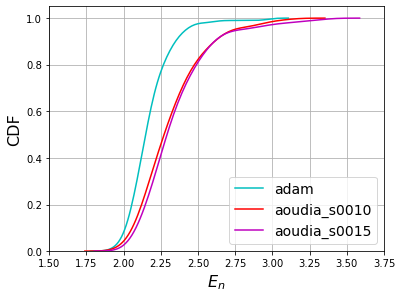

In [17]:
# colors = cycle(['b', 'g', 'c', 'r', 'm', 'y'])
colors = cycle(['c', 'r', 'm', 'y'])
fig = plt.figure(figsize=(4*1.5,3*1.5))

# # Plot lines for traditional methods
# plt.plot(2*[results_traditional["QAM"]["en"]], [0,1], linewidth=3, label="QAM", color=next(colors), linestyle="-.")
# plt.plot(2*[results_traditional["Agrell"]["en"]], [0,1], linewidth=3, label="Agrell", color=next(colors), linestyle="-.")

for (label, result) in results.items():
    clr = next(colors)
    sns.distplot(result["en"], label=label, color=clr,
                 bins=100,
                 rug=False, 
                 
                 kde=True, 
                 kde_kws=dict(cumulative=True, 
                              linestyle=":" if "Oshea" in label or "[1]" in label else "-"),
                 
                 hist=False,
                 hist_kws=dict(cumulative=True, 
                               density=True, 
                               histtype="step", 
                               linestyle=":" if "Oshea" in label or "[1]" in label else "-",
                               linewidth=2,
                               color=clr, alpha=1.0))

plt.xlim([1.5, 3.75])
plt.xlabel("$E_n$", fontdict={'fontsize':16})
plt.ylabel("CDF", fontdict={'fontsize':16})
plt.grid()
plt.legend(loc='lower right', prop={'size':14})
plt.savefig("aoudia_output_rbf_en_{:02d}x{:02d}.pdf".format(blkSize,chDim), format='pdf', bbox_inches='tight')
robinhood(fig, "aoudia_output_rbf_en_{:02d}x{:02d}.csv".format(blkSize,chDim))

Plot results: BLER

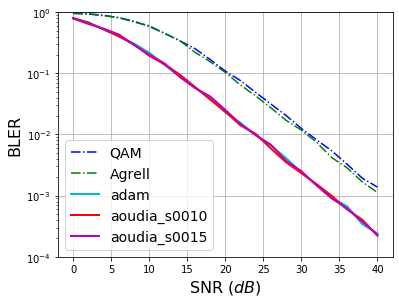

In [18]:
colors = cycle(['b', 'g', 'c', 'r', 'm', 'y'])
fig = plt.figure(figsize=(4*1.5,3*1.5))

plt.semilogy(SNR_range_dB, results_traditional["QAM"]["bler"], label="QAM", color=next(colors), linestyle="-.")
plt.semilogy(SNR_range_dB, results_traditional["Agrell"]["bler"], label="Agrell", color=next(colors), linestyle="-.")

for (label, result) in results.items():
    best_model_id = result['en'].idxmin()  # Find the model with best E_n
    plt.semilogy(SNR_range_dB, 
                 result.loc[best_model_id]["bler"], 
                 label=label, color=next(colors), linewidth=2,
                 linestyle=":" if "Oshea" in label or "[1]" in label else "-")
plt.legend(loc="lower left", prop={'size':14})
plt.grid()
# plt.title("Best observed BLER of trained models", fontdict={'fontsize':18})
plt.xlabel("SNR ($dB$)", fontdict={'fontsize':16})
plt.ylabel("BLER", fontdict={'fontsize':16})
plt.ylim((1e-4,1e0))
plt.savefig("aoudia_output_rbf_best_bler_{:02d}x{:02d}.pdf".format(blkSize,chDim), format='pdf', bbox_inches='tight')
robinhood(fig, "aoudia_output_rbf_best_bler_{:02d}x{:02d}.csv".format(blkSize,chDim), col_dtype=[int, float])

Plot results: BLER with confidence

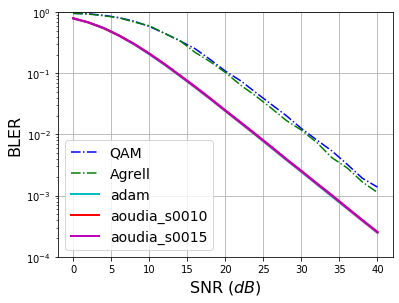

In [19]:
colors = cycle(['b', 'g', 'c', 'r', 'm', 'y'])
plt.figure(figsize=(4*1.5,3*1.5))

plt.semilogy(SNR_range_dB, results_traditional["QAM"]["bler"], label="QAM", color=next(colors), linestyle="-.")
plt.semilogy(SNR_range_dB, results_traditional["Agrell"]["bler"], label="Agrell", color=next(colors), linestyle="-.")

for (label, result) in results.items():
    clr = next(colors)
    bler_mean = result["bler"].mean()
    bler_std  = np.array(result['bler']).std()
    plt.fill_between(SNR_range_dB, bler_mean+bler_std, bler_mean-bler_std, alpha=0.1, color=clr)
    
    plt.semilogy(SNR_range_dB, 
                 result["bler"].mean(), 
                 label=label, color=clr, linewidth=2,
                 linestyle=":" if "Oshea" in label or "[1]" in label else "-")
plt.legend(loc="lower left", prop={'size':14})
plt.grid()
# plt.title("Best observed BLER of trained models", fontdict={'fontsize':18})
plt.xlabel("SNR ($dB$)", fontdict={'fontsize':16})
plt.ylabel("BLER", fontdict={'fontsize':16})
plt.ylim((1e-4,1e0))
plt.savefig("output_rbf_avg_bler_{:02d}x{:02d}.pdf".format(blkSize,chDim), format='pdf', bbox_inches='tight')